In [8]:
#%% 1. Setup és dinamikus kimeneti dim beállítása
import sys, os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

sys.path.append(os.path.abspath(".."))
from complex_mlp.model import ComplexMLP

# Adat betöltése
data = np.load("../data/processed/dataset_preProcessed.npz")
X = data["images"].reshape(len(data["images"]), -1) / 255.0
y = data["labels"]

# Train/val split
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

input_dim = X_tr.shape[1]           # pl. 768
n_classes = len(np.unique(y_tr))    # pl. 9

# Most a layer_sizes utolsó elemét ne 10-re, hanem n_classes-re állítjuk
layer_sizes = [input_dim, 512, n_classes]
activations = ["tanh", "softmax"]



In [9]:
#%% 2. One-hot a megfelelő dim-mal az MSE-hez
y_tr_hot  = np.eye(n_classes)[y_tr]    # shape=(N, n_classes)
y_val_hot = np.eye(n_classes)[y_val]


In [10]:
#%% 3. Loss-konfigurációk, mindkettő ugyanazzal a layer_sizes-szel
loss_configs = {
    "cross_entropy": {
        "loss":   "cross_entropy",
        "y_tr":   y_tr,
        "y_val":  y_val
    },
    "mse": {
        "loss":   "mse",
        "y_tr":   y_tr_hot,
        "y_val":  y_val_hot
    }
}


In [11]:
#%% 4. Tesztciklus
results = []
for name, cfg in loss_configs.items():
    print(f"--- Teszt: {name} ---")
    model = ComplexMLP(
        layer_sizes=layer_sizes,
        activations=activations,
        loss=cfg["loss"],
        optimizer="sgd",
        optimizer_kwargs={"lr":0.001},
        early_stopping=False
    )
    history = model.train(
        X_train=X_tr, y_train=cfg["y_tr"],
        X_val=X_val,   y_val=cfg["y_val"],
        epochs=10, batch_size=32
    )
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"{name} → val_accuracy = {acc:.4f}\n")
    results.append({"loss": name, "val_accuracy": acc})

df = pd.DataFrame(results).sort_values("val_accuracy", ascending=False)
display(df)



--- Teszt: cross_entropy ---
Epoch 1/10  train_loss=0.8321  val_loss=0.7100
Epoch 2/10  train_loss=0.6241  val_loss=0.5483
Epoch 3/10  train_loss=0.4941  val_loss=0.4489
Epoch 4/10  train_loss=0.4188  val_loss=0.3921
Epoch 5/10  train_loss=0.3744  val_loss=0.3577
Epoch 6/10  train_loss=0.3464  val_loss=0.3347
Epoch 7/10  train_loss=0.3278  val_loss=0.3188
Epoch 8/10  train_loss=0.3145  val_loss=0.3073
Epoch 9/10  train_loss=0.3043  val_loss=0.2991
Epoch 10/10  train_loss=0.2965  val_loss=0.2932
cross_entropy → val_accuracy = 0.8994

--- Teszt: mse ---
Epoch 1/10  train_loss=0.0376  val_loss=0.0289
Epoch 2/10  train_loss=0.0238  val_loss=0.0200
Epoch 3/10  train_loss=0.0188  val_loss=0.0177
Epoch 4/10  train_loss=0.0171  val_loss=0.0163
Epoch 5/10  train_loss=0.0162  val_loss=0.0156
Epoch 6/10  train_loss=0.0157  val_loss=0.0156
Epoch 7/10  train_loss=0.0154  val_loss=0.0150
Epoch 8/10  train_loss=0.0152  val_loss=0.0147
Epoch 9/10  train_loss=0.0150  val_loss=0.0148
Epoch 10/10  train_

,loss,val_accuracy
1,mse,0.907104
0,cross_entropy,0.899350


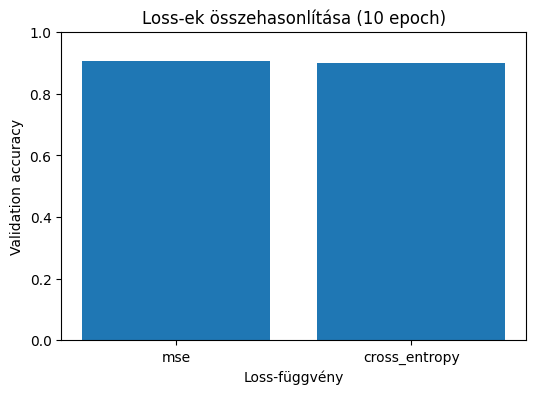

In [12]:
#%% 5. Eredmények ábrázolása
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(df["loss"], df["val_accuracy"])
plt.xlabel("Loss-függvény")
plt.ylabel("Validation accuracy")
plt.title("Loss-ek összehasonlítása (10 epoch)")
plt.ylim(0,1)
plt.show()
